# Table of contents

1. [Introduction](#intro)
2. [Import dependencies](#import_dep)
3. [Load the dataset](#load_data)
4. [Initial data exploration](#ide)

# 1. Introduction
<a class="anchor" id="intro"></a>

These sets of notebooks introduce document classifier that's able to successfully identify articles that contain drug-target interaction information and those that do not. In the previous notebook, we queried the ChEMBL database and generated our analysis dataset. In this notebook, we explore the dataset and brainstorm which features we may want to include in our model.

# 2. Import dependencies
<a class="anchor" id="import_dep"></a>

In [1]:
# Base packages
import os
import string
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
import matplotlib.pyplot as plt
from google.cloud import bigquery

# Scikit-learn packages
from sklearn.feature_extraction.text import CountVectorizer

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Define relative paths
NOTEBOOKS = os.getcwd()
ROOT = NOTEBOOKS.replace('Document_clf/Notebooks', '')
WKDIR = NOTEBOOKS.replace('/Notebooks', '')
INPUT = WKDIR + '/Input'
DATA = WKDIR + '/Data'

# 3. Load the dataset
<a class="anchor" id="load_data"></a>

Let's load in the dataset we created in the previous notebook.

In [2]:
# Load the data
data_pos = pd.read_csv(DATA + '/ChEMBL document data (positive).csv')
data_neg = pd.read_csv(DATA + '/ChEMBL document data (negative).csv')

In the previous notebook, we determined that there were about ~30k of both 'positive' and 'negative' articles, and that the dataset was roughly balanced. Unfortunately, since we're going to be tokenizing the document titles and abstracts to generate our features, it would be prohibitively expensive to use a dataset with ~60K documents (we'd create too many unique bigrams). Therefore, we randomly select 6,000 documents from each class to populate our dataset.

In [3]:
data_pos_6k = data_pos.sample(n=6000, random_state=42)
data_neg_6k = data_neg.sample(n=6000, random_state=42)

# Confirm that we don't have any duplicate doc_ids
data = data_pos_6k.append(data_neg_6k)
data.duplicated(subset=['doc_id']).value_counts()

False    12000
dtype: int64

Let's create our analysis dataset.

In [4]:
data = data[['title', 'abstract', 'target']]
data.to_csv(DATA + '/ChEMBL document data (all, 6k).csv', index=False)
data.head()

,title,abstract,target
22690,"Cyanidin-3-rutinoside, a natural polyphenol an...",Anthocyanins are a group of naturally occurrin...,1
14620,2012 Division of medicinal chemistry award add...,My involvement with the field of cannabinoids ...,1
19242,Discovery and functional evaluation of diverse...,Ligand-based virtual screening with a 3D pharm...,1
21051,Structure-activity relationships of new inhibi...,At the end of the last century tariquidar (XR9...,1
11550,"Design, synthesis, and correlation analysis of...",Fifteen 7-substituted 4-hydroxyquinoline-3-car...,1


# 4. Initial data exploration
<a class="anchor" id="ide"></a>

Let's start by exploring the length of the title and the abstract for the documents in our corpus. We hypothesize that title length and abstract length will have little predictive power, since it's intuitively unlikely that the number of words in an abstract has any effect on whether the document contains drug-target interaction information.

In [5]:
data_explore = data
data_explore['title_length'] = data['title'].apply(lambda x: len(x.split()))
data_explore['abstract_length'] = data['abstract'].apply(lambda x: len(x.split()))

To test our hypothesis, let's first check whether there are significant differences in the mean title length and abstract length across the various classes.

In [6]:
means = {}
for var in ['title', 'abstract']:
    means[f'{var}_1'] = np.mean(data_explore.loc[data_explore['target']==1][f'{var}_length'])
    means[f'{var}_0'] = np.mean(data_explore.loc[data_explore['target']==0][f'{var}_length']) 
    print(f'The mean {var} length for class 1 is: ' + str(means[f'{var}_1']))
    print(f'The mean {var} length for class 0 is: ' + str(means[f'{var}_0']))

The mean title length for class 1 is: 13.691
The mean title length for class 0 is: 12.580166666666667
The mean abstract length for class 1 is: 120.3535
The mean abstract length for class 0 is: 120.35683333333333


As we suspected, there doesn't seem to be much of a difference between the title and abstract length across classes. Let's further confirm this by generating box-and-whisker plots.

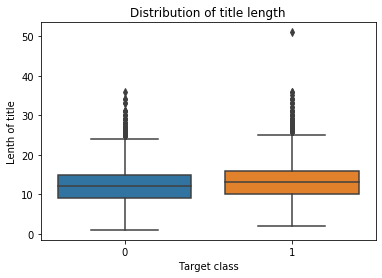

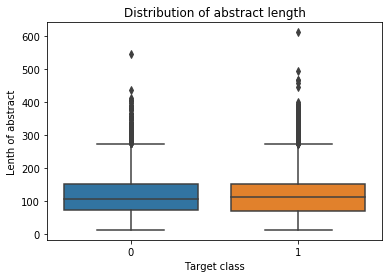

In [7]:
def box_and_whisker(data, var):
    sns.boxplot(x='target', y=f'{var}_length', data=data)
    plt.xlabel('Target class')
    plt.ylabel(f'Lenth of {var}')
    plt.title(f'Distribution of {var} length')
    plt.show()

box_and_whisker(data_explore, 'title')
box_and_whisker(data_explore, 'abstract')

Alright, so the length of the title and abstract won't be of much help when generating our model. 

Next, let's try representing the data using the bag-of-words (or, more generally, bag-of-ngram) model. An ngram is defined as a contiguous sequence of *n* items from a text. For instance, a 1-gram (i.e., unigram), is simply a single word; a 2-gram (i.e., bigram) is a series to two adjacent words; a 3-gram (i.e., trigram) is a series of three adjacent words, and so on.

In a bag-of-ngram model, all the unique ngrams in the corpus, or collection of texts, form a dictionary *D*. A document is represented as a 1 x |*D*| array of ngram counts. The model is called a “bag” of ngrams, because any information about the order or structure of the ngrams in the document is discarded. For example, consider the following title: "Depolarization, bacterial membrane composition, and the antimicrobial action of ceragenins." If we were to represent this document using the bag-of-bigram model, we would represent it using the following vector:

| Depolarization_bacterial | bacterial_membrane | membrane_composition | composition_and | and_the | the_antimicrobial | antimicrobial_action | action_of | of_ceragenins |
|--------------------------|--------------------| -------------------- | --------------- | ------- | --------------------------------- | ---------------------| --------- | ------------- |
|            1             |          1         |           1          |        1        |    1    | 1                                 | 1                    | 1         | 1             |

We can implement the above tokenization using the CountVectorizer module. The "ngram_range" parameter allows us to specify whether we want to generate frequency counts for unigrams, bigrams, or both. Note that we remove stopwords (i.e., useless words, like articles and pronouns) to reduce the number of features in our data.

In [8]:
def generate_frequency(data, vars, ngram):
    """Generate a dataframe containing the frequency of the inputted n-grams

    Keyword arguments:
    data  -- the data to be tokenized
    vars  -- the list of string vars from which to generate tokens
    ngram -- a tuple containing the range of n-grams to tokenize
    """
    # Concatenate the input vars
    data['combined'] = data[vars].apply(lambda x: ' '.join(x), axis=1)
    
    # Initialize the CountVectorizer and fit it to the data
    cv = CountVectorizer(token_pattern='(?u)\\b\\w\\w+\\b', stop_words='english', ngram_range=ngram)
    freq = cv.fit_transform(data['combined']).toarray()
    
    # Convert to dataframe
    col_names = cv.get_feature_names()
    freq_df = pd.DataFrame(data=freq, columns=col_names, index=data.index)
    return freq_df
    
# Create the unigram and bigram dataframes
unigram_freq = generate_frequency(data_explore, ['title', 'abstract'], ngram=(1,1))
bigram_freq = generate_frequency(data_explore, ['title', 'abstract'], ngram=(2,2))

# Add a 'target' column to each dataframe
unigram_freq['target'] = data_explore['target']
bigram_freq['target'] = data_explore['target']

One (simple) method which we can use to test whether or not we've defined our frequency dataframes correctly is to examine the shape of the unigram frequency table and compare it to that of the bigram frequency table. We would expect there to be far more unique bigrams across the corpus.

Consider the word "regulatory." Since this word is (obviously) a unique unigram, it will constitute a single variable in the unigram frequency dataset. The individual row values for this variable will be the frequency of this word in the document associated with that row. However, this word may be associated with different bigrams in every document it appears in. For instance, it could appear in the phrase "regulatory approval" in one, "regulatory pathway," in another, and so on. These bigrams are distinct, and so will appear as distinct columns in the bigram frequency dataset.

In [9]:
print("Number of unique unigrams: " + str(unigram_freq.shape[1]))
print("Number of unique bigrams: " + str(bigram_freq.shape[1]))

Number of unique unigrams: 52437
Number of unique bigrams: 555595


As expected, the number of bigrams is nearly 10x the number of unigrams. Let's now explore the most frequent unigrams and bigrams across the different classes.

In [10]:
def transpose_df(df):
    """Transpose the data in order to frequency counts for each of the grams across the different classes
    
    Keyword arguments:
    data -- the data to transpose
    """
    # Collapse the data and transpose
    data = df.groupby(['target']).sum()
    data = data.transpose()
    
    # Clean up dataframe for readability
    data['Ngram'] = data.index
    data.reset_index(inplace=True, drop=True)
    data.index.name = 'index'
    data = data[['Ngram', 0, 1]]
    data.columns = ['Ngram', 'Negative', 'Positive']
    
    # Return
    return data
    
unigram_freq_class = transpose_df(unigram_freq)
unigram_freq_class.head()

,Ngram,Negative,Positive
index,,,
0,00,21,8
1,000,53,86
2,00007,1,0
3,0001,10,0
4,00013,1,0


Next, we define a custom function to create our frequency chart.

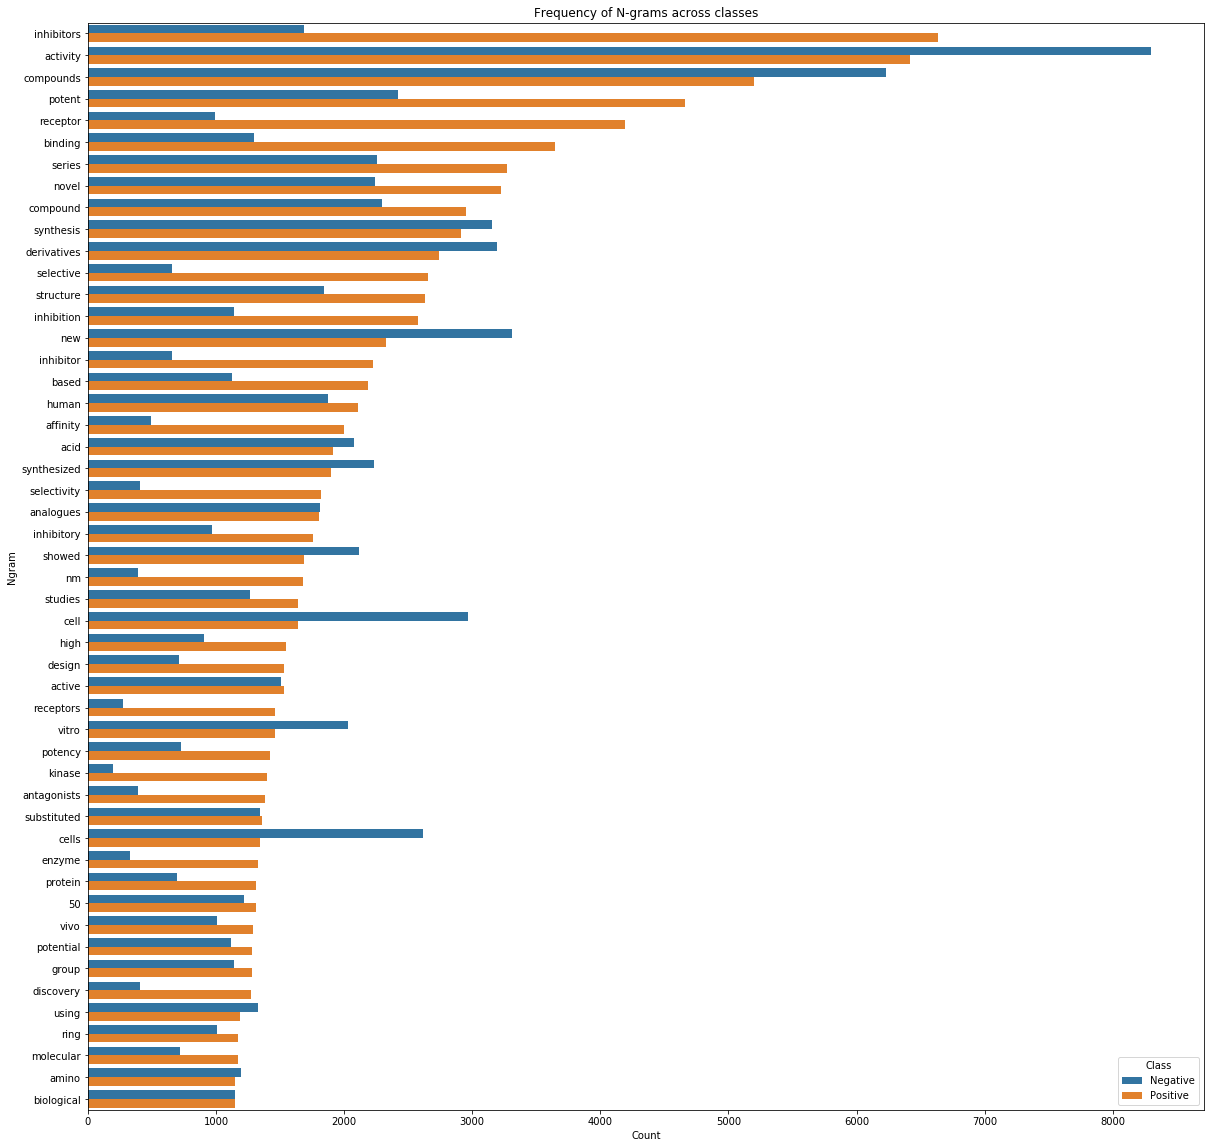

In [11]:
# Define the plot size
plt.rcParams["figure.figsize"] = (20,20)

def frequency_chart(df, x, sort_by):
    """Create a bar chart summarizing the frequency of the top x unigrams. This function is meant to 
    complement transpose_df
    
    Keyword arguments:
    data    -- the frequency data to chart 
    x       -- threshold for how many unigrams the chart should display
    sort_by -- class order by which to sort unigrams
    """
    
    # Store the sorted order
    df.sort_values(by=sort_by, ascending=False, inplace=True)
    df = df.iloc[0:x,]
    
    # Reshape the dataframe long by n-gram and class
    data = df.melt(id_vars=['Ngram'], value_vars=['Negative', 'Positive'], var_name='Class', value_name='Count')
    
    # Plot
    ax = sns.barplot(x='Count', y='Ngram', hue='Class', data=data, orient="h")
    ax.set(xlabel='Count', ylabel='Ngram', title='Frequency of N-grams across classes')
    plt.show()

# Display the relatively frequency of the top 50 unigrams in the 'Positive' class
frequency_chart(unigram_freq_class, 50, ['Positive', 'Negative'])

The above graph depicts the relative frequency of the top 50 unigrams that appeared in positively labeled articles. At first glance, it seems pretty informative. For example, it clearly shows that there are several words whose frequency is quite different across classes. Some of these are expected--"inhibitor," "potent," "receptor," "selective," "kinase," and so forth. Some of these are little unexpected. For example, it's strange that "compounds" and "activity" appear more in negatively labeled articles than positively labeled ones. Nevertheless, it validates using a BoW model to generate the classifier.

In any case, let's now explore the most common bigrams across the corpus. Calling transpose_df on our bigram dataset would cause the code to crash, because the corpus contains >500k unique bigrams (i.e., columns). In order to prevent a single function call from eating up a prohibitive amount of memory, we'll tranpose our bigram dataset in buckets and append the transposed buckets afterwards.

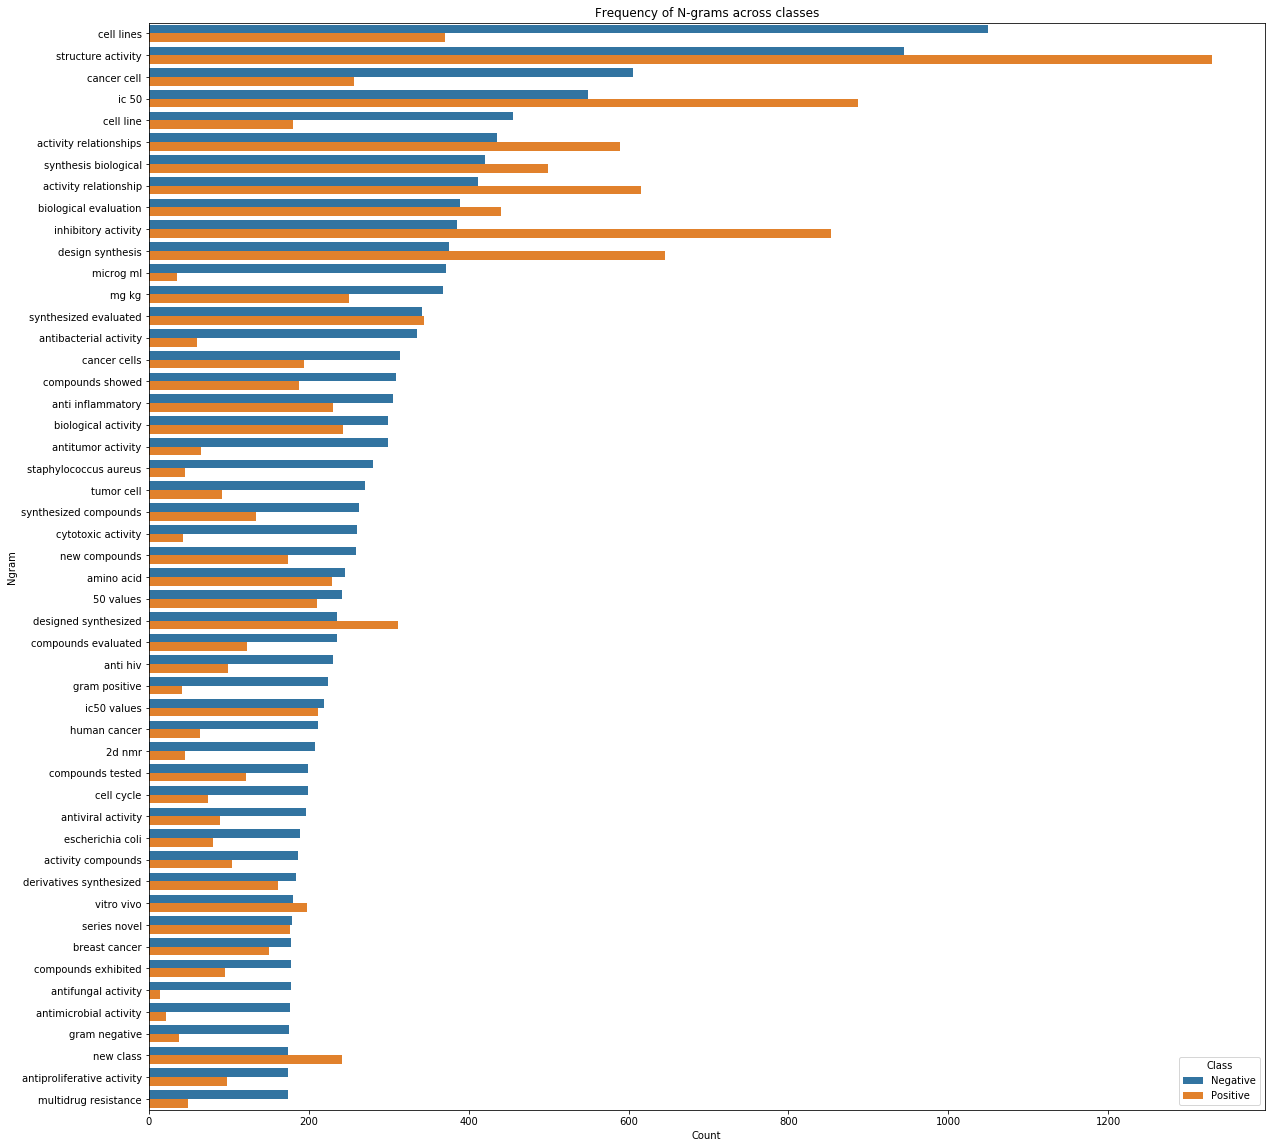

In [12]:
# Define the buckets
bigram_buckets = {}
for i in range(0, bigram_freq.shape[1], 1000):
    # Subset the dataset to only 5k features at a time
    if i==555000:
        temp = bigram_freq.iloc[:,i:]
    else:
        temp = bigram_freq.iloc[:,i:i+1000]
        temp['target'] = bigram_freq.iloc[:,-1]
    
    # Transpose the subsetted dataset
    transposed_temp = transpose_df(temp)
    
    # Add the dataset to the map
    j = int(i/1000)
    bigram_buckets[f'bucket{j}'] = transposed_temp
    
# Append the buckets together
bigram_freq_class = bigram_buckets['bucket0']
for i in range(1, len(bigram_buckets.keys())):
    bigram_freq_class = bigram_freq_class.append(bigram_buckets[f'bucket{i}'], ignore_index=True)
    
# Generate the chart
frequency_chart(bigram_freq_class, 50, ['Negative', 'Positive'])

As with the unigram frequency chart, the above bigram frequency chart validates using a bag-of-bigram model to generate our classifier. In the next section, we'll explicitly define pipelines to implement these models.